# **Uploading and extracting the zip file**

In [ ]:
import zipfile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the direct download link
direct_download_link = 'https://drive.google.com/uc?id=1EYUtAL0oi46ZCl-hNmb0h-qeap-_a90X'

# Extract the zip file
with zipfile.ZipFile('/content/drive/MyDrive/Datasets/daily+and+sports+activities.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')


Mounted at /content/drive


# **Preprocess the dataset to be ready for clustering.**

In [ ]:
import os
import numpy as np
import pandas as pd


# Define a function to process the data for the first approach (45 features per data point)
def process_data_mean(folder_path, activity_label):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path, header=None, usecols=range(45))
            mean_vector = df.mean().values.tolist()
            data.append(mean_vector)
            labels.append(activity_label)
    return data, labels

# Define a function to process the data for the second approach (5625 features per data point)
def process_data_flatten(folder_path, activity_label):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path, header=None)
            flattened_data = df.values.flatten().tolist()  # Flatten all features into one list
            data.append(flattened_data)
            labels.append(activity_label)
    return data, labels

# Process data for all activities and persons using both approaches
dataset_mean = []
dataset_flatten = []
labels_mean = []
labels_flatten = []
activities = ['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19']
persons = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

for idx, activity in enumerate(activities, 1):
    activity_label = f'activity_{idx:02d}'
    for person in persons:
        folder_path = os.path.join('/content/data/data', activity, person)
        if os.path.exists(folder_path):
            activity_data_mean, activity_labels_mean = process_data_mean(folder_path, activity_label)
            activity_data_flatten, activity_labels_flatten = process_data_flatten(folder_path, activity_label)
            dataset_mean.extend(activity_data_mean)
            dataset_flatten.extend(activity_data_flatten)
            labels_mean.extend(activity_labels_mean)
            labels_flatten.extend(activity_labels_flatten)

# Convert datasets and labels to numpy arrays for clustering
dataset_mean = np.array(dataset_mean)
dataset_flatten = np.array(dataset_flatten)
labels_mean = np.array(labels_mean)
labels_flatten = np.array(labels_flatten)

# Now 'dataset_mean' contains the preprocessed data with 45 features per data point and the corresponding labels
# 'dataset_flatten' contains the preprocessed data with 5625 features per data point and the corresponding labels

print("Shape of dataset_mean:", dataset_mean.shape)
print("Shape of dataset_flatten:", dataset_flatten.shape)
print("Shape of labels_mean:", labels_mean.shape)
print("Shape of labels_flatten:", labels_flatten.shape)

# Print the number of unique values
unique_values, counts = np.unique(labels_mean, return_counts=True)
print("Number of unique values:", len(unique_values))
print("Unique values: ", unique_values)

Shape of dataset_mean: (9120, 45)
Shape of dataset_flatten: (9120, 5625)
Shape of labels_mean: (9120,)
Shape of labels_flatten: (9120,)
Number of unique values: 19
Unique values:  ['activity_01' 'activity_02' 'activity_03' 'activity_04' 'activity_05'
 'activity_06' 'activity_07' 'activity_08' 'activity_09' 'activity_10'
 'activity_11' 'activity_12' 'activity_13' 'activity_14' 'activity_15'
 'activity_16' 'activity_17' 'activity_18' 'activity_19']


# **Reduce the number of dimensions of the dataset_flatten**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ensure that dataset_flatten is not empty
if dataset_flatten.size == 0:
    print("Error: No data found in dataset_flatten.")
else:
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset_flatten)

    # Check if scaled_data is not empty
    if scaled_data.size == 0:
        print("Error: No data after scaling.")
    else:
        # Apply PCA to reduce dimensions
        pca = PCA(n_components=100)
        projected_data = pca.fit_transform(scaled_data)

        print("Shape of projected_data:", projected_data.shape)


Shape of projected_data: (9120, 100)


# **Converts categorical labels into numeric labels.**

In [ ]:
def label_to_number(labels):
    label_dict = {}
    number_labels = []
    count = 1

    for label in labels:
        if label not in label_dict:
            label_dict[label] = count
            count += 1
        number_labels.append(label_dict[label])

    return number_labels

numeric_labels = label_to_number(labels_mean)
y_true = [x - 1 for x in numeric_labels]

# **Train and test split**

In [ ]:
import numpy as np

def split_data_with_pattern(data, train_size=48, skip_size=12):

  # Calculate the total number of training chunks
  num_chunks = int(len(data) / (train_size + skip_size))

  # Create empty lists to store training and test data
  train_data = []
  test_data = []

  # Loop through the chunks
  for i in range(num_chunks):
    # Get the start and end indices for the training chunk
    start_train = i * (train_size + skip_size)
    end_train = start_train + train_size

    # Get the start and end indices for the test chunk (skipped rows)
    start_test = start_train + train_size
    end_test = start_test + skip_size

    # Append training data to the list if it's not empty
    if len(data[start_train:end_train]) > 0:
        train_data.append(data[start_train:end_train])

    # Append test data to the list if it's not empty
    if len(data[start_test:end_test]) > 0:
        test_data.append(data[start_test:end_test])

  # Concatenate the lists into NumPy arrays if they are not empty
  if train_data:
    train_data = np.concatenate(train_data)
  else:
    train_data = np.array([])  # Return an empty array if train_data is empty

  if test_data:
    test_data = np.concatenate(test_data)
  else:
    test_data = np.array([])  # Return an empty array if test_data is empty

  return train_data, test_data

# Train and Test of labels
y_train, y_test = split_data_with_pattern(y_true)

# Train and Test of dataset mean
x_train_mean, x_test_mean = split_data_with_pattern(dataset_mean)

# Train and Test of dataset flatten
x_train_flatten, x_test_flatten = split_data_with_pattern(projected_data)

print("Training data:", x_train_flatten.shape)
print("Test data:", x_test_flatten.shape)


Training data: (7296, 100)
Test data: (1824, 100)


In [ ]:
def map_max_occurrences(array1, array2):
    # Create dictionaries to store occurrences of values in array2
    occurrences = {}

    # Count occurrences of values in array2 corresponding to values in array1
    for value1, value2 in zip(array1, array2):
        if value1 not in occurrences:
            occurrences[value1] = {}
        if value2 not in occurrences[value1]:
            occurrences[value1][value2] = 0
        occurrences[value1][value2] += 1

    # Find the value in array2 with the maximum occurrences for each value in array1
    max_occurrences_values = {}
    for value1, counts in occurrences.items():
        max_occurrences_values[value1] = max(counts, key=counts.get)

    # Map occurrences of the values in array1 to the values in array2
    mapped_array2 = [max_occurrences_values[value] for value in array1]

    return mapped_array2


# **Clustering Using K-Means**

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

def k_means(X, k, max_iters=100):
    # Initialize centroids randomly
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        # Assign each point to the nearest centroid
        labels = pairwise_distances_argmin_min(X, centroids)[0]

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

# Define K values
k_values = [8, 13, 19, 28, 38]

# **Clustering Evaluation**

NaN values handled successfully.


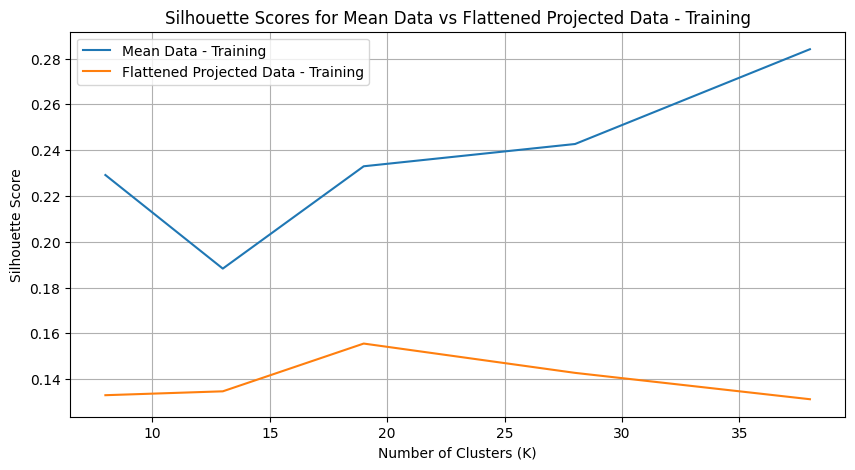

--------------------------------------------------------------------------------------------


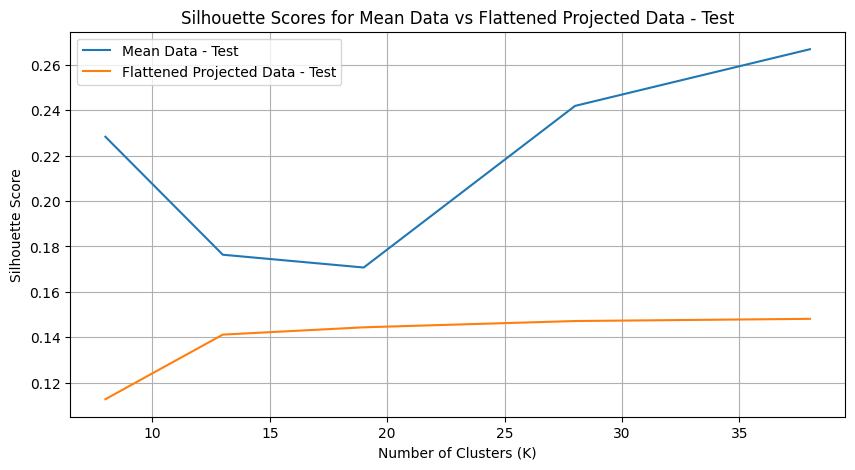

K = 8 - Mean Data - Training:
Precision: 0.34
Recall: 0.34
F1 Score: 0.34
Conditional Entropy: 1.28
Silhouette Score: 0.23
-----------------------------------------
K = 13 - Mean Data - Training:
Precision: 0.36
Recall: 0.36
F1 Score: 0.36
Conditional Entropy: 1.38
Silhouette Score: 0.19
-----------------------------------------
K = 19 - Mean Data - Training:
Precision: 0.45
Recall: 0.45
F1 Score: 0.45
Conditional Entropy: 1.53
Silhouette Score: 0.23
-----------------------------------------
K = 28 - Mean Data - Training:
Precision: 0.45
Recall: 0.45
F1 Score: 0.45
Conditional Entropy: 1.54
Silhouette Score: 0.24
-----------------------------------------
K = 38 - Mean Data - Training:
Precision: 0.56
Recall: 0.56
F1 Score: 0.56
Conditional Entropy: 1.76
Silhouette Score: 0.28
-----------------------------------------
K = 8 - Mean Data - Test:
Precision: 0.35
Recall: 0.35
F1 Score: 0.35
Conditional Entropy: 1.26
Silhouette Score: 0.23
-----------------------------------------
K = 13 - M

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, mutual_info_score, silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer

# Define K values
k_values = [8, 13, 19, 28, 38]

# Initialize lists to store clustering results and evaluation metrics for mean data
mean_precision_scores_train = []
mean_recall_scores_train = []
mean_f1_scores_train = []
mean_conditional_entropy_scores_train = []
mean_silhouette_scores_train = []

mean_precision_scores_test = []
mean_recall_scores_test = []
mean_f1_scores_test = []
mean_conditional_entropy_scores_test = []
mean_silhouette_scores_test = []

# Initialize lists to store evaluation metrics for flattened projected data
flattened_precision_scores_train = []
flattened_recall_scores_train = []
flattened_f1_scores_train = []
flattened_conditional_entropy_scores_train = []
flattened_silhouette_scores_train = []

flattened_precision_scores_test = []
flattened_recall_scores_test = []
flattened_f1_scores_test = []
flattened_conditional_entropy_scores_test = []
flattened_silhouette_scores_test = []

# Define zero_division parameter for precision, recall, and F1 score
zero_division_param = 1

# Identify NaN values in the NumPy array
nan_indices = np.isnan(x_train_flatten).any(axis=0)
nan_columns = np.where(nan_indices)[0]

# Replace NaN values with the mean of each column
column_means = np.nanmean(x_train_flatten, axis=0)
x_train_flatten_filled = np.where(np.isnan(x_train_flatten), column_means, x_train_flatten)

# Check if there are any remaining NaN values
if np.isnan(x_train_flatten_filled).any():
    print("NaN values still exist after filling.")
else:
    print("NaN values handled successfully.")

# Perform K-Means clustering and evaluation for each k value on mean data and flattened data
for k in k_values:
    # Perform clustering using K-Means on mean data for training data
    mean_labels_train, mean_centroids_train = k_means(x_train_mean, k)
    predicted_mean_labels_train = map_max_occurrences(mean_labels_train, y_train)

    # Calculate evaluation metrics for mean data on training data
    mean_precision_train = precision_score(y_train, predicted_mean_labels_train, average='micro', zero_division=zero_division_param)
    mean_recall_train = recall_score(y_train, predicted_mean_labels_train, average='micro', zero_division=zero_division_param)
    mean_f1_train = f1_score(y_train, predicted_mean_labels_train, average='micro', zero_division=zero_division_param)
    mean_conditional_entropy_train = mutual_info_score(y_train, predicted_mean_labels_train)
    mean_silhouette_train = silhouette_score(x_train_mean, mean_labels_train)

    # Store evaluation scores for mean data on training data
    mean_precision_scores_train.append(mean_precision_train)
    mean_recall_scores_train.append(mean_recall_train)
    mean_f1_scores_train.append(mean_f1_train)
    mean_conditional_entropy_scores_train.append(mean_conditional_entropy_train)
    mean_silhouette_scores_train.append(mean_silhouette_train)

    # Perform clustering using K-Means on mean data for test data
    mean_labels_test, mean_centroids_test = k_means(x_test_mean, k)
    predicted_mean_labels_test = map_max_occurrences(mean_labels_test, y_test)

    # Calculate evaluation metrics for mean data on test data
    mean_precision_test = precision_score(y_test, predicted_mean_labels_test, average='micro', zero_division=zero_division_param)
    mean_recall_test = recall_score(y_test, predicted_mean_labels_test, average='micro', zero_division=zero_division_param)
    mean_f1_test = f1_score(y_test, predicted_mean_labels_test, average='micro', zero_division=zero_division_param)
    mean_conditional_entropy_test = mutual_info_score(y_test, predicted_mean_labels_test)
    mean_silhouette_test = silhouette_score(x_test_mean, mean_labels_test)

    # Store evaluation scores for mean data on test data
    mean_precision_scores_test.append(mean_precision_test)
    mean_recall_scores_test.append(mean_recall_test)
    mean_f1_scores_test.append(mean_f1_test)
    mean_conditional_entropy_scores_test.append(mean_conditional_entropy_test)
    mean_silhouette_scores_test.append(mean_silhouette_test)

    # Create an imputer object with strategy as mean
    imputer = SimpleImputer(strategy='mean')

    # Fit and transform the data
    x_train_flatten_imputed = imputer.fit_transform(x_train_flatten)

    # Perform clustering using K-Means on flattened projected data for training data
    flattened_labels_train, flattened_centroids_train = k_means(x_train_flatten, k)
    predicted_flattened_labels_train = map_max_occurrences(flattened_labels_train, y_train)

    # Calculate evaluation metrics for flattened projected data on training data
    flattened_precision_train = precision_score(y_train, predicted_flattened_labels_train, average='macro', zero_division=zero_division_param)
    flattened_recall_train = recall_score(y_train, predicted_flattened_labels_train, average='macro', zero_division=zero_division_param)
    flattened_f1_train = f1_score(y_train, predicted_flattened_labels_train, average='macro', zero_division=zero_division_param)
    flattened_conditional_entropy_train = mutual_info_score(y_train, predicted_flattened_labels_train)
    flattened_silhouette_train = silhouette_score(x_train_flatten, flattened_labels_train)

    # Store evaluation scores for flattened projected data on training data
    flattened_precision_scores_train.append(flattened_precision_train)
    flattened_recall_scores_train.append(flattened_recall_train)
    flattened_f1_scores_train.append(flattened_f1_train)
    flattened_conditional_entropy_scores_train.append(flattened_conditional_entropy_train)
    flattened_silhouette_scores_train.append(flattened_silhouette_train)

    # Perform clustering using K-Means on flattened projected data for test data
    flattened_labels_test, flattened_centroids_test = k_means(x_test_flatten, k)
    predicted_flattened_labels_test = map_max_occurrences(flattened_labels_test, y_test)

    # Calculate evaluation metrics for flattened projected data on test data
    flattened_precision_test = precision_score(y_test, predicted_flattened_labels_test, average='macro', zero_division=zero_division_param)
    flattened_recall_test = recall_score(y_test, predicted_flattened_labels_test, average='macro', zero_division=zero_division_param)
    flattened_f1_test = f1_score(y_test, predicted_flattened_labels_test, average='macro', zero_division=zero_division_param)
    flattened_conditional_entropy_test = mutual_info_score(y_test, predicted_flattened_labels_test)
    flattened_silhouette_test = silhouette_score(x_test_flatten, flattened_labels_test)

    # Store evaluation scores for flattened projected data on test data
    flattened_precision_scores_test.append(flattened_precision_test)
    flattened_recall_scores_test.append(flattened_recall_test)
    flattened_f1_scores_test.append(flattened_f1_test)
    flattened_conditional_entropy_scores_test.append(flattened_conditional_entropy_test)
    flattened_silhouette_scores_test.append(flattened_silhouette_test)


# Visualize silhouette scores for training data
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_silhouette_scores_train, label='Mean Data - Training')
plt.plot(k_values, flattened_silhouette_scores_train, label='Flattened Projected Data - Training')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Mean Data vs Flattened Projected Data - Training')
plt.legend()
plt.grid(True)
plt.show()
print("--------------------------------------------------------------------------------------------")
# Visualize silhouette scores for test data
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_silhouette_scores_test, label='Mean Data - Test')
plt.plot(k_values, flattened_silhouette_scores_test, label='Flattened Projected Data - Test')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Mean Data vs Flattened Projected Data - Test')
plt.legend()
plt.grid(True)
plt.show()


# Print evaluation metrics for each k value for mean data on training data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Mean Data - Training:")
    print("Precision:", round(mean_precision_scores_train[idx], 2))
    print("Recall:", round(mean_recall_scores_train[idx], 2))
    print("F1 Score:", round(mean_f1_scores_train[idx], 2))
    print("Conditional Entropy:", round(mean_conditional_entropy_scores_train[idx], 2))
    print("Silhouette Score:", round(mean_silhouette_scores_train[idx], 2))
    print("-----------------------------------------")

# Print evaluation metrics for each k value for mean data on test data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Mean Data - Test:")
    print("Precision:", round(mean_precision_scores_test[idx], 2))
    print("Recall:", round(mean_recall_scores_test[idx], 2))
    print("F1 Score:", round(mean_f1_scores_test[idx], 2))
    print("Conditional Entropy:", round(mean_conditional_entropy_scores_test[idx], 2))
    print("Silhouette Score:", round(mean_silhouette_scores_test[idx], 2))
    print("-----------------------------------------")

# Print evaluation metrics for each k value for flattened projected data on training data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Flattened Projected Data - Training:")
    print("Precision:", round(flattened_precision_scores_train[idx], 2))
    print("Recall:", round(flattened_recall_scores_train[idx], 2))
    print("F1 Score:", round(flattened_f1_scores_train[idx], 2))
    print("Conditional Entropy:", round(flattened_conditional_entropy_scores_train[idx], 2))
    print("Silhouette Score:", round(flattened_silhouette_scores_train[idx], 2))
    print("-----------------------------------------")

# Print evaluation metrics for each k value for flattened projected data on test data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Flattened Projected Data - Test:")
    print("Precision:", round(flattened_precision_scores_test[idx], 2))
    print("Recall:", round(flattened_recall_scores_test[idx], 2))
    print("F1 Score:", round(flattened_f1_scores_test[idx], 2))
    print("Conditional Entropy:", round(flattened_conditional_entropy_scores_test[idx], 2))
    print("Silhouette Score:", round(flattened_silhouette_scores_test[idx], 2))
    print("-----------------------------------------")

# **Clustering Using DBSCAN**

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, mutual_info_score, silhouette_score

class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None

    def fit_predict(self, X):
        self.labels = np.zeros(len(X))  # Initialize cluster labels as 0 (unassigned)

        cluster_label = 0  # Cluster label counter

        for i in range(len(X)):
            if self.labels[i] != 0:  # Skip points that have already been assigned to a cluster
                continue

            neighbors = self.region_query(X, i)

            if len(neighbors) < self.min_samples:  # Assign noise label (cluster label = -1)
                self.labels[i] = -1
            else:
                cluster_label += 1
                self.expand_cluster(X, i, neighbors, cluster_label)

        return self.labels

    def region_query(self, X, index):
        neighbors = []
        for i in range(len(X)):
            if np.linalg.norm(X[index] - X[i]) < self.eps:
                neighbors.append(i)
        return neighbors

    def expand_cluster(self, X, index, neighbors, cluster_label):
        self.labels[index] = cluster_label
        i = 0
        while i < len(neighbors):
            neighbor_index = neighbors[i]
            if self.labels[neighbor_index] == -1:  # Assign core point neighbor noise label to border point
                self.labels[neighbor_index] = cluster_label
            elif self.labels[neighbor_index] == 0:  # Process unassigned neighbors
                self.labels[neighbor_index] = cluster_label
                new_neighbors = self.region_query(X, neighbor_index)
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors
            i += 1

# Define a list of eps and min_samples values to try
eps_values = [2, 3]
min_samples_values = [2, 3]

for eps in eps_values:
    for min_samples in min_samples_values:
        print("eps: ", eps)
        print("min_samples: ", min_samples)
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_pred = dbscan.fit_predict(x_test_mean)
        print(labels_pred.shape)

        # Evaluate clustering
        silhouette = silhouette_score(x_test_mean, labels_pred)
        print("Silhouette Score:", round(silhouette, 2))

        predicted_labels = map_max_occurrences(labels_pred, y_test)
        precision = precision_score(y_test, predicted_labels, average='macro')
        print("Precision:", round(precision, 2))

        # Calculate recall
        recall = recall_score(y_test, predicted_labels, average='macro')
        print(f"Recall: {round(recall, 2)}")

        # Calculate F1 score
        f1 = f1_score(y_test, predicted_labels, average='macro')
        print(f"F1 Score: {round(f1, 2)}")

        # Calculate conditional entropy (assuming y_true is the true distribution)
        conditional_entropy = mutual_info_score(y_test, predicted_labels)
        print(f"Conditional Entropy: {round(conditional_entropy, 2)}")
        print("---------------------------")


eps:  2
min_samples:  2
(1824,)
Silhouette Score: 0.46
Precision: 0.88
Recall: 0.81
F1 Score: 0.81
Conditional Entropy: 2.34
---------------------------
eps:  2
min_samples:  3
(1824,)
Silhouette Score: 0.43
Precision: 0.88
Recall: 0.79
F1 Score: 0.79
Conditional Entropy: 2.26
---------------------------
eps:  3
min_samples:  2
(1824,)
Silhouette Score: 0.36
Precision: 0.85
Recall: 0.63
F1 Score: 0.63
Conditional Entropy: 1.97
---------------------------
eps:  3
min_samples:  3
(1824,)
Silhouette Score: 0.36
Precision: 0.85
Recall: 0.62
F1 Score: 0.62
Conditional Entropy: 1.93
---------------------------


In [ ]:
# import numpy as np
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.model_selection import GridSearchCV

# # Define a function to calculate silhouette score as a scorer
# def silhouette_scorer(estimator, X):
#     labels = estimator.fit_predict(X)
#     return silhouette_score(X, labels)

# # Example data
# # X = np.random.rand(100, 2)  # Example data, replace with your own data

# # Define the parameter grid for DBSCAN
# param_grid = {'eps': [0.1, 0.5, 1.0, 5, 10, 15],
#               'min_samples': [5, 10, 20, 40, 80]}

# # Initialize DBSCAN
# dbscan = DBSCAN()

# # Initialize GridSearchCV with custom scoring function
# grid_search = GridSearchCV(dbscan, param_grid, scoring=silhouette_scorer)

# # Perform grid search
# grid_search.fit(x_test_flatten)

# # Best parameters
# print("Best parameters:", grid_search.best_params_)

# # Best silhouette score
# print("Best silhouette score:", grid_search.best_score_)


### **Normalized Cut**


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_projected: [6 6 6 ... 3 3 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_means: [0 0 0 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_projected: [5 5 5 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_means: [0 0 0 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_projected: [13 13 13 ...  7  7  7]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_means: [0 0 0 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_projected: [24 24 24 ...  0  0  0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_means: [0 0 0 ... 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_projected: [35 35 35 ... 24 24 24]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels_means: [0 0 0 ... 0 0 0]


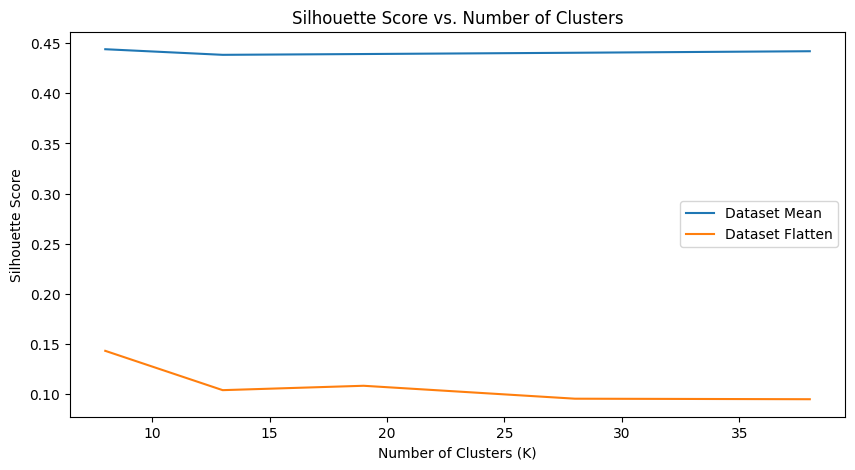

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.sparse import csgraph
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def helper_spectral_clustering(data, sigma=1):

    # Construct affinity matrix using cosine similarity
    affinity_matrix = cosine_similarity(data)
    #print(affinity_matrix)
    # Compute degree matrix
    degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))

    # Compute Laplacian matrix
    laplacian_matrix = degree_matrix - affinity_matrix

    # Compute k smallest eigenvectors of the normalized Laplacian
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

    # Step 3: Sort eigenvectors based on the smallest eigenvalues
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvectors


def spectral_clustering( eigenvectors ,n_clusters):

    # Use KMeans from scikit-learn
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(eigenvectors)

    return cluster_labels



# Initialize lists to store clustering results
cluster_labels_mean_list = []
cluster_labels_projected_list = []
silhouette_scores_mean = []
silhouette_scores_projected = []

eigenvectors_projected = helper_spectral_clustering(projected_data)
eigenvectors_mean = helper_spectral_clustering(dataset_mean)

n_clusters_list = [8, 13, 19, 28, 38]
for n_clusters in n_clusters_list:
    selected_eigenvectors_projected = eigenvectors_projected[:,:n_clusters]
    cluster_labels_projected = spectral_clustering(selected_eigenvectors_projected, n_clusters)
    cluster_labels_projected_list.append(cluster_labels_projected)
    silhouette_scores_projected.append(silhouette_score(projected_data, cluster_labels_projected))
    print("Cluster Labels_projected:", cluster_labels_projected)
    selected_eigenvectors_mean = eigenvectors_mean[:,:n_clusters]
    cluster_labels_means = spectral_clustering( selected_eigenvectors_mean , n_clusters)
    cluster_labels_mean_list.append(cluster_labels_projected)
    silhouette_scores_mean.append(silhouette_score(dataset_mean, cluster_labels_means))
    print("Cluster Labels_means:", cluster_labels_means)


# Visualize silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_list, silhouette_scores_mean, label='Dataset Mean')
plt.plot(n_clusters_list, silhouette_scores_projected, label='Dataset Flatten')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def map_cluster_labels(true_labels, cluster_labels):
    """
    Map cluster labels to ground truth labels using the confusion matrix.
    """
    cm = confusion_matrix(true_labels, cluster_labels)
    unique_true_labels = np.unique(true_labels)
    cluster_to_gt_mapping = {}
    for label in unique_true_labels:
        max_value = -1  # Initialize max value
        cluster_label = -1  # Initialize cluster label
        for i, count in enumerate(cm[label]):
            if count > max_value:  # Check if current count is greater than max_value
                max_value = count
                cluster_label = i
        cluster_to_gt_mapping[cluster_label] = label

    mapped_labels = [cluster_to_gt_mapping.get(label, -1) for label in cluster_labels]
    return mapped_labels

def evaluate_clustering(true_labels, cluster_labels):
    """
    Evaluate clustering performance using precision, recall, F1 score, and conditional entropy.
    """
    # Map cluster labels to ground truth labels
    mapped_labels = map_cluster_labels(true_labels, cluster_labels)

    # Calculate evaluation metrics
    precision = precision_score(true_labels, mapped_labels, average='weighted')
    recall = recall_score(true_labels, mapped_labels, average='weighted')
    f1 = f1_score(true_labels, mapped_labels, average='weighted')

    # Calculate conditional entropy
    true_counts = np.bincount(true_labels)
    cluster_counts = np.bincount(cluster_labels)
    joint_counts = np.bincount(np.ravel_multi_index([true_labels, cluster_labels], (len(true_counts), len(cluster_counts))))
    true_probs = true_counts / len(true_labels)
    cluster_probs = cluster_counts / len(cluster_labels)
    joint_probs = joint_counts / len(true_labels)
    true_counts = np.bincount(true_labels)
    cluster_counts = np.bincount(cluster_labels)

    # Calculate joint counts
    joint_counts = np.zeros((len(true_counts), len(cluster_counts)))
    for i in range(len(true_labels)):
        joint_counts[true_labels[i], cluster_labels[i]] += 1

    # Calculate probabilities
    true_probs = true_counts / len(true_labels)
    cluster_probs = cluster_counts / len(cluster_labels)
    joint_probs = joint_counts / len(true_labels)

    # Avoid division by zero
    joint_probs[joint_probs == 0] = 1e-10

    # Calculate conditional entropy
    conditional_entropy = -np.sum(joint_probs * np.log2(joint_probs / cluster_probs))

    return precision, recall, f1, conditional_entropy

# Example usage
# true_labels_mean = labels_mean
# Convert string labels to numeric labels
for i in range(5):

    label_encoder = LabelEncoder()
    true_labels_numeric = label_encoder.fit_transform(labels_flatten)
    true_labels_flatten = true_labels_numeric
    label_encoder = LabelEncoder()
    true_labels_numeric = label_encoder.fit_transform(labels_mean)
    true_labels_mean = true_labels_numeric
    cluster_labels_mean = cluster_labels_mean_list[i]
    cluster_labels_projected = cluster_labels_projected_list[i]

    precision_mean, recall_mean, f1_mean, conditional_entropy_mean = evaluate_clustering(true_labels_mean, cluster_labels_mean)
    precision_projected, recall_projected, f1_projected, conditional_entropy_projected = evaluate_clustering( true_labels_flatten , cluster_labels_projected)
    print("---------------------------------------")
    print("Precision_mean:", precision_mean)
    print("Recall_mean:", recall_mean)
    print("F1 Score_mean:", f1_mean)
    print("Conditional Entropy_mean:", conditional_entropy_mean)
    print("----------------------------------------")
    print("Precision_projected:", precision_projected)
    print("Recall_projected:", recall_projected)
    print("F1 Score_projected:", f1_projected)
    print("Conditional Entropy_projected:", conditional_entropy_projected)

---------------------------------------
Precision_mean: 0.1865250333786719
Recall_mean: 0.268530701754386
F1 Score_mean: 0.20157818996855897
Conditional Entropy_mean: 2.369913154171254
----------------------------------------
Precision_projected: 0.1865250333786719
Recall_projected: 0.268530701754386
F1 Score_projected: 0.20157818996855897
Conditional Entropy_projected: 2.369913154171254
---------------------------------------
Precision_mean: 0.18668953759919157
Recall_mean: 0.26875
F1 Score_mean: 0.2020098597298402
Conditional Entropy_mean: 2.344954067249046
----------------------------------------
Precision_projected: 0.18668953759919157
Recall_projected: 0.26875
F1 Score_projected: 0.2020098597298402
Conditional Entropy_projected: 2.344954067249046
---------------------------------------
Precision_mean: 0.18008946892878158
Recall_mean: 0.262390350877193
F1 Score_mean: 0.19495060691699434
Conditional Entropy_mean: 2.2803348868828914
----------------------------------------
Precision_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

K = 8 - Mean Data:
Precision: 0.06
Recall: 0.06
F1 Score: 0.06
Conditional Entropy: 0.02
Silhouette Score: 0.44
-----------------------------------------
K = 13 - Mean Data:
Precision: 0.05
Recall: 0.05
F1 Score: 0.05
Conditional Entropy: 0.0
Silhouette Score: 0.44
-----------------------------------------
K = 19 - Mean Data:
Precision: 0.05
Recall: 0.05
F1 Score: 0.05
Conditional Entropy: 0.01
Silhouette Score: 0.44
-----------------------------------------
K = 28 - Mean Data:
Precision: 0.06
Recall: 0.06
F1 Score: 0.06
Conditional Entropy: 0.01
Silhouette Score: 0.44
-----------------------------------------
K = 38 - Mean Data:
Precision: 0.06
Recall: 0.06
F1 Score: 0.06
Conditional Entropy: 0.01
Silhouette Score: 0.44
-----------------------------------------
K = 8 - Flattened Projected Data:
Precision: 0.21
Recall: 0.36
F1 Score: 0.24
Conditional Entropy: 1.31
Silhouette Score: 0.14
-----------------------------------------
K = 13 - Flattened Projected Data:
Precision: 0.2
Recall: 

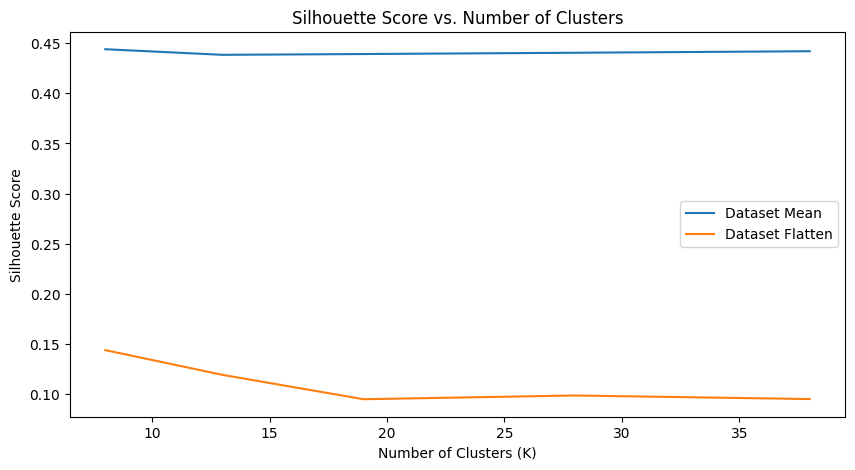

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, mutual_info_score, silhouette_score
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.sparse import csgraph
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import confusion_matrix

# Suppress UndefinedMetricWarning
# warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
def map_cluster_labels(true_labels, cluster_labels):
    """
    Map cluster labels to ground truth labels using the confusion matrix.
    """
    cm = confusion_matrix(true_labels, cluster_labels)
    unique_true_labels = np.unique(true_labels)
    cluster_to_gt_mapping = {}
    for label in unique_true_labels:
        max_value = -1  # Initialize max value
        cluster_label = -1  # Initialize cluster label
        for i, count in enumerate(cm[label]):
            if count > max_value:  # Check if current count is greater than max_value
                max_value = count
                cluster_label = i
        cluster_to_gt_mapping[cluster_label] = label

    mapped_labels = [cluster_to_gt_mapping.get(label, -1) for label in cluster_labels]
    return mapped_labels
def helper_spectral_clustering(data, sigma=1):

    # Construct affinity matrix using cosine similarity
    affinity_matrix = cosine_similarity(data)
    #print(affinity_matrix)
    # Compute degree matrix
    degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))

    # Compute Laplacian matrix
    laplacian_matrix = degree_matrix - affinity_matrix

    # Compute k smallest eigenvectors of the normalized Laplacian
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

    # Step 3: Sort eigenvectors based on the smallest eigenvalues
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvectors


def spectral_clustering( eigenvectors ,n_clusters):

    # Use KMeans from scikit-learn
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(eigenvectors)

    return cluster_labels

# Define K values
k_values = [8, 13, 19, 28, 38]

# Initialize lists to store clustering results and evaluation metrics for mean data
mean_precision_scores = []
mean_recall_scores = []
mean_f1_scores = []
mean_conditional_entropy_scores = []
mean_silhouette_scores = []

# Initialize lists to store evaluation metrics for flattened projected data
flattened_precision_scores = []
flattened_recall_scores = []
flattened_f1_scores = []
flattened_conditional_entropy_scores = []
flattened_silhouette_scores = []

eigenvectors_projected = helper_spectral_clustering(projected_data)
eigenvectors_mean = helper_spectral_clustering(dataset_mean)
# Perform spectural clustering and evaluation for each k value on mean data and flattened data
for k in k_values:
    # Perform clustering using spectural on mean data
    selected_eigenvectors_mean = eigenvectors_mean[:,:k]
    mean_labels= spectral_clustering( selected_eigenvectors_mean , k)
    predicted_mean_labels = map_max_occurrences(mean_labels, y_true)

    # Calculate evaluation metrics for mean data
    mean_precision = precision_score(y_true, predicted_mean_labels, average='micro')
    mean_recall = recall_score(y_true, predicted_mean_labels, average='micro')
    mean_f1 = f1_score(y_true, predicted_mean_labels, average='micro')
    mean_conditional_entropy = mutual_info_score(y_true, predicted_mean_labels)
    mean_silhouette = silhouette_score(dataset_mean, mean_labels)

    # Store evaluation scores for mean data
    mean_precision_scores.append(mean_precision)
    mean_recall_scores.append(mean_recall)
    mean_f1_scores.append(mean_f1)
    mean_conditional_entropy_scores.append(mean_conditional_entropy)
    mean_silhouette_scores.append(mean_silhouette)

    # Perform clustering using K-Means on flattened projected data
    selected_eigenvectors_projected = eigenvectors_projected[:,:k]
    flattened_labels =  spectral_clustering(selected_eigenvectors_projected, k)
    predicted_flattened_labels = map_max_occurrences(flattened_labels, y_true)

    # Calculate evaluation metrics for flattened projected data
    flattened_precision = precision_score(y_true, predicted_flattened_labels, average='macro')
    flattened_recall = recall_score(y_true, predicted_flattened_labels, average='macro')
    flattened_f1 = f1_score(y_true, predicted_flattened_labels, average='macro')
    flattened_conditional_entropy = mutual_info_score(y_true, predicted_flattened_labels)
    flattened_silhouette = silhouette_score(projected_data, flattened_labels)

    # Store evaluation scores for flattened projected data
    flattened_precision_scores.append(flattened_precision)
    flattened_recall_scores.append(flattened_recall)
    flattened_f1_scores.append(flattened_f1)
    flattened_conditional_entropy_scores.append(flattened_conditional_entropy)
    flattened_silhouette_scores.append(flattened_silhouette)

# Print evaluation metrics for each k value for mean data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Mean Data:")
    print("Precision:", round(mean_precision_scores[idx], 2))
    print("Recall:", round(mean_recall_scores[idx], 2))
    print("F1 Score:", round(mean_f1_scores[idx], 2))
    print("Conditional Entropy:", round(mean_conditional_entropy_scores[idx], 2))
    print("Silhouette Score:", round(mean_silhouette_scores[idx], 2))
    print("-----------------------------------------")

# Print evaluation metrics for each k value for flattened projected data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Flattened Projected Data:")
    print("Precision:", round(flattened_precision_scores[idx], 2))
    print("Recall:", round(flattened_recall_scores[idx], 2))
    print("F1 Score:", round(flattened_f1_scores[idx], 2))
    print("Conditional Entropy:", round(flattened_conditional_entropy_scores[idx], 2))
    print("Silhouette Score:", round(flattened_silhouette_scores[idx], 2))
    print("-----------------------------------------")


# Visualize silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_silhouette_scores, label='Dataset Mean')
plt.plot(k_values, flattened_silhouette_scores, label='Dataset Flatten')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

K = 8 - Mean Data:
Precision: 0.06
Recall: 0.06
F1 Score: 0.06
Conditional Entropy: 0.02
Silhouette Score: 0.44
-----------------------------------------
K = 13 - Mean Data:
Precision: 0.05
Recall: 0.05
F1 Score: 0.05
Conditional Entropy: 0.0
Silhouette Score: 0.44
-----------------------------------------
K = 19 - Mean Data:
Precision: 0.05
Recall: 0.05
F1 Score: 0.05
Conditional Entropy: 0.01
Silhouette Score: 0.44
-----------------------------------------
K = 28 - Mean Data:
Precision: 0.06
Recall: 0.06
F1 Score: 0.06
Conditional Entropy: 0.01
Silhouette Score: 0.44
-----------------------------------------
K = 38 - Mean Data:
Precision: 0.06
Recall: 0.06
F1 Score: 0.06
Conditional Entropy: 0.01
Silhouette Score: 0.44
-----------------------------------------
K = 8 - Flattened Projected Data:
Precision: 0.21
Recall: 0.36
F1 Score: 0.24
Conditional Entropy: 1.31
Silhouette Score: 0.14
-----------------------------------------
K = 13 - Flattened Projected Data:
Precision: 0.18
Recall:

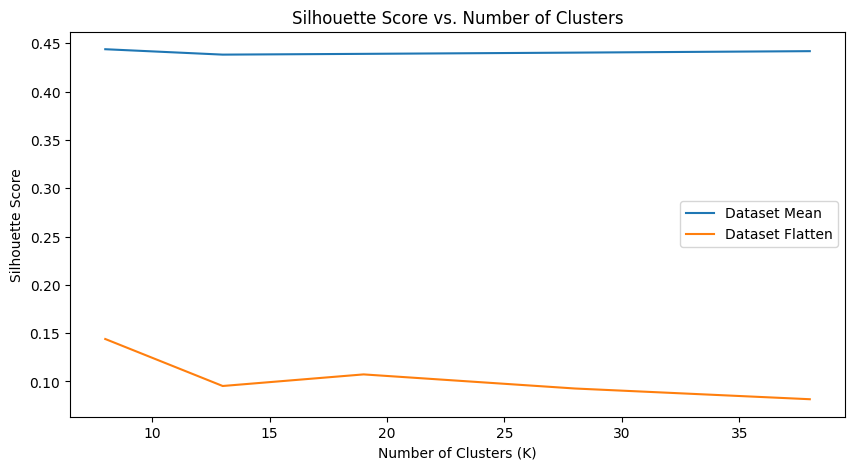

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
k_values = [8, 13, 19, 28, 38]
def map_cluster_labels(true_labels, cluster_labels):
    """
    Map cluster labels to ground truth labels using the confusion matrix.
    """
    cm = confusion_matrix(true_labels, cluster_labels)
    unique_true_labels = np.unique(true_labels)
    cluster_to_gt_mapping ={}
    for label in unique_true_labels:
        # print(label)
        cluster_label = np.argmax(cm[label])
        cluster_to_gt_mapping[cluster_label] = label

    mapped_labels = [cluster_to_gt_mapping.get(label, -1) for label in cluster_labels]
    return mapped_labels
# Initialize lists to store clustering results and evaluation metrics for mean data
mean_precision_scores = []
mean_recall_scores = []
mean_f1_scores = []
mean_conditional_entropy_scores = []
mean_silhouette_scores = []

# Initialize lists to store evaluation metrics for flattened projected data
flattened_precision_scores = []
flattened_recall_scores = []
flattened_f1_scores = []
flattened_conditional_entropy_scores = []
flattened_silhouette_scores = []

label_encoder = LabelEncoder()
true_labels_numeric = label_encoder.fit_transform(labels_flatten)
true_labels_flatten = true_labels_numeric
label_encoder = LabelEncoder()
true_labels_numeric = label_encoder.fit_transform(labels_mean)
true_labels_mean = true_labels_numeric

# Perform spectural clustering and evaluation for each k value on mean data and flattened data
for k in k_values:
    # Perform clustering using spectural on mean data
    selected_eigenvectors_mean = eigenvectors_mean[:,:k]
    mean_labels= spectral_clustering( selected_eigenvectors_mean , k)
    predicted_mean_labels = map_max_occurrences(mean_labels, true_labels_mean)

    # Calculate evaluation metrics for mean data
    mean_precision = precision_score(true_labels_mean, predicted_mean_labels, average='micro')
    mean_recall = recall_score(true_labels_mean, predicted_mean_labels, average='micro')
    mean_f1 = f1_score(true_labels_mean, predicted_mean_labels, average='micro')
    mean_conditional_entropy = mutual_info_score(true_labels_mean, predicted_mean_labels)
    mean_silhouette = silhouette_score(dataset_mean, mean_labels)

    # Store evaluation scores for mean data
    mean_precision_scores.append(mean_precision)
    mean_recall_scores.append(mean_recall)
    mean_f1_scores.append(mean_f1)
    mean_conditional_entropy_scores.append(mean_conditional_entropy)
    mean_silhouette_scores.append(mean_silhouette)

    # Perform clustering using K-Means on flattened projected data
    selected_eigenvectors_projected = eigenvectors_projected[:,:k]
    flattened_labels =  spectral_clustering(selected_eigenvectors_projected, k)
    predicted_flattened_labels = map_max_occurrences(flattened_labels, true_labels_flatten)

    # Calculate evaluation metrics for flattened projected data
    flattened_precision = precision_score(true_labels_flatten, predicted_flattened_labels, average='macro')
    flattened_recall = recall_score(true_labels_flatten, predicted_flattened_labels, average='macro')
    flattened_f1 = f1_score(true_labels_flatten, predicted_flattened_labels, average='macro')
    flattened_conditional_entropy = mutual_info_score(true_labels_flatten, predicted_flattened_labels)
    flattened_silhouette = silhouette_score(projected_data, flattened_labels)

    # Store evaluation scores for flattened projected data
    flattened_precision_scores.append(flattened_precision)
    flattened_recall_scores.append(flattened_recall)
    flattened_f1_scores.append(flattened_f1)
    flattened_conditional_entropy_scores.append(flattened_conditional_entropy)
    flattened_silhouette_scores.append(flattened_silhouette)

# Print evaluation metrics for each k value for mean data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Mean Data:")
    print("Precision:", round(mean_precision_scores[idx], 2))
    print("Recall:", round(mean_recall_scores[idx], 2))
    print("F1 Score:", round(mean_f1_scores[idx], 2))
    print("Conditional Entropy:", round(mean_conditional_entropy_scores[idx], 2))
    print("Silhouette Score:", round(mean_silhouette_scores[idx], 2))
    print("-----------------------------------------")

# Print evaluation metrics for each k value for flattened projected data
for idx, k in enumerate(k_values):
    print(f"K = {k} - Flattened Projected Data:")
    print("Precision:", round(flattened_precision_scores[idx], 2))
    print("Recall:", round(flattened_recall_scores[idx], 2))
    print("F1 Score:", round(flattened_f1_scores[idx], 2))
    print("Conditional Entropy:", round(flattened_conditional_entropy_scores[idx], 2))
    print("Silhouette Score:", round(flattened_silhouette_scores[idx], 2))
    print("-----------------------------------------")


# Visualize silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_silhouette_scores, label='Dataset Mean')
plt.plot(k_values, flattened_silhouette_scores, label='Dataset Flatten')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()
plt.show()